# FPP STEP v1.7 benchmarking 

In [49]:
using Revise
using FUSE
using IMAS
using Plots;
FUSE.logging(Logging.Info);

## Make new FPP equilibirum from scratch

### Initialize from FPP v1_demount

In [50]:
dd = IMAS.dd();
ini, act = FUSE.case_parameters(:FPP, version=:v1_demount, init_from=:scalars);
#display(ini)

### Modify ini

In [51]:
ini.equilibrium.R0 = 4.82
ini.equilibrium.B0 = 4.71
ini.equilibrium.ip = 8e6
ini.equilibrium.ϵ = 1/3.5
ini.equilibrium.κ = 2.19
ini.equilibrium.δ = 0.7
ini.equilibrium.ζ = 0.0
ini.equilibrium.pressure_core = 2.0e6

ini.build.plasma_gap = 0.125
ini.build.layers[:hfs_vacuum_vessel] += ini.build.layers[:hfs_vacuum_vessel_wall_inner] + ini.build.layers[:hfs_vacuum_vessel_wall_outer]
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_outer)
ini.build.layers[:lfs_vacuum_vessel] += ini.build.layers[:lfs_vacuum_vessel_wall_inner] + ini.build.layers[:lfs_vacuum_vessel_wall_outer]
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_outer)

ini.core_profiles.impurity = :Kr
ini.core_profiles.n_shaping = 2.5
ini.core_profiles.T_shaping = 2.5
ini.core_profiles.T_ratio = 0.808
ini.core_profiles.greenwald_fraction = 1.2
ini.core_profiles.ne_ped = 1.0e20
ini.core_profiles.greenwald_fraction_ped = missing
ini.core_profiles.helium_fraction = 0.04

ini.equilibrium.boundary_from = :scalars
ini.equilibrium.xpoints = :double
ini.build.divertors = :lower
ini.equilibrium.field_null_surface = 0.5

ini.ec_launchers.power_launched = 67.2e6

ini.pf_active.n_coils_outside = 8

ini.gasc.filename = missing
ini.gasc.case = missing

ini.requirements.flattop_duration = 24*3600

86400

### Modify act

In [52]:
act.ActorEquilibrium.model = :Solovev
act.ActorEquilibrium.symmetrize = false
act.ActorTEQUILA.free_boundary = true
act.ActorTEQUILA.do_plot = false
act.ActorTEQUILA.debug = false

act.ActorCHEASE.free_boundary = false
act.ActorCXbuild.rebuild_wall = true

act.ActorHFSsizing.do_plot = true
act.ActorHFSsizing.verbose = true
act.ActorHFSsizing.j_tolerance = 0.5
act.ActorHFSsizing.stress_tolerance = 0.01
act.ActorHFSsizing.aspect_ratio_tolerance = 0.0

act.ActorEquilibriumTransport.max_iter = 1
act.ActorEquilibriumTransport.convergence_error = 1e-2
act.ActorEquilibriumTransport.do_plot = true
act.ActorTauenn.transport_model = :ds03
act.ActorTauenn.confinement_factor = 1.0
act.ActorTauenn.T_shaping = 2.5
act.ActorTauenn.T_ratio_pedestal = 0.808
act.ActorTauenn.error = 1e-3
act.ActorTauenn.eped_only_powerlaw = true # more reliable for broader exploration

act.ActorPFcoilsOpt.do_plot = true
act.ActorPFcoilsOpt.symmetric = true
act.ActorPFcoilsOpt.update_equilibrium = false
act.ActorPFcoilsOpt.optimization_scheme = :currents

act.ActorPowerNeeds.model = :thermal_power_fraction
act.ActorPowerNeeds.thermal_power_fraction = 0.1

act.ActorThermalCycle.power_cycle_type = :fixed_cycle_efficiency
act.ActorThermalCycle.fixed_cycle_efficiency = 0.438

act.ActorCosting.model = :Sheffield

:Sheffield

## Run WholeFacility Actor

In [53]:
dd = IMAS.dd();
@time FUSE.init(dd, ini, act; do_plot=false);
#FUSE.digest(dd)

 14.282445 seconds (43.16 M allocations: 5.180 GiB, 4.07% gc time)


### Modify dd IMAS parameters

In [54]:
dd.build.layer[8].material = "Steel, Stainless 316"
dd.build.layer[18].material = "Steel, Stainless 316"
dd.build.layer[24].material = "Steel, Stainless 316"
dd.build.tf.technology.temperature = 4.5
dd.build.oh.technology.temperature = 4.5

4.5

 * Status: success

 * Candidate solution
    Final objective value:     2.343029e-04

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    263
    f(x) calls:    517


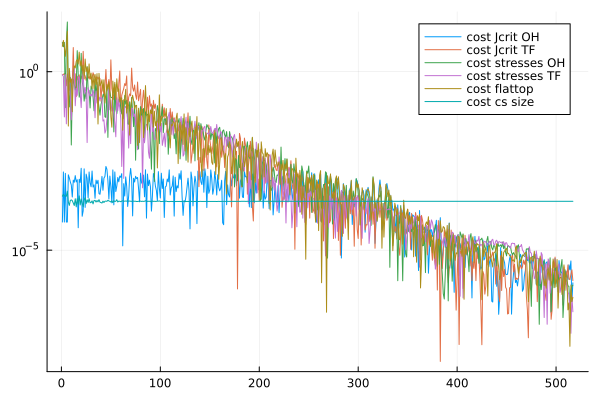

[OH.thickness, dd.build.oh.technology.fraction_stainless] = [0.2542872071282787, 0.7107364743827685]
[TFhfs.thickness, dd.build.tf.technology.fraction_stainless] = [0.4155013250509967, 0.8030132925762512]

target_B0 = 4.710018675752262
(dd.build.tf.max_b_field * TFhfs.end_radius) / R0 = 4.710018675752262

dd.build.oh.flattop_duration = 86399.91448632609
dd.requirements.flattop_duration = 86400.0

dd.build.oh.max_j = 5.255636302434748e7
dd.build.oh.critical_j = 7.88345304983877e7

dd.build.tf.max_j = 3.2772956865891885e7
dd.build.tf.critical_j = 4.915942962833661e7

maximum(dd.solid_mechanics.center_stack.stress.vonmises.oh) = 7.920793598136005e8
stainless_steel.yield_strength = 8.0e8

maximum(dd.solid_mechanics.center_stack.stress.vonmises.tf) = 7.920804514763021e8
stainless_steel.yield_strength = 8.0e8

old_R0 / a = 3.111200390589292
R0 / a = 3.111200390589292


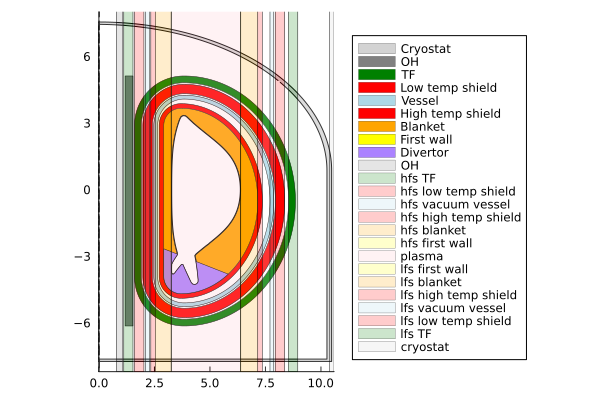

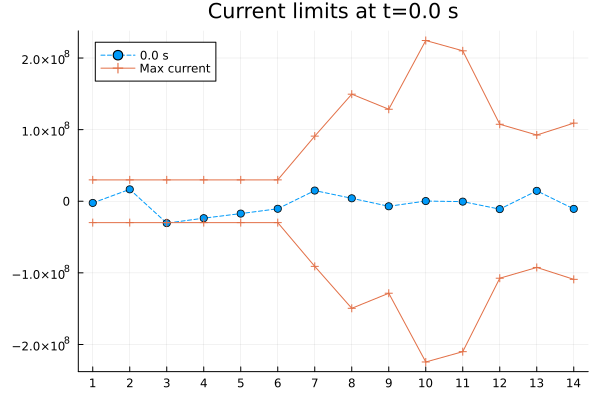

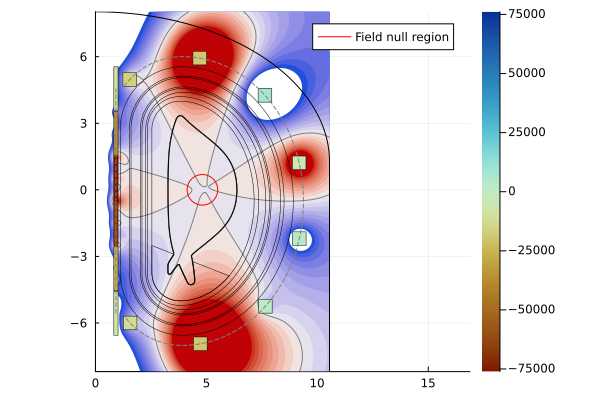

 74.253108 seconds (175.97 M allocations: 5.400 GiB, 1.48% gc time, 0.19% compilation time)


In [55]:
@time FUSE.ActorOpt(dd, act);

## Summary

GEOMETRY                        EQUILIBRIUM                     TEMPERATURES                    DENSITIES                       
────────────────────────────    ────────────────────────────    ────────────────────────────    ────────────────────────────    
R0 → 4.82 [m]                   B0 → 4.71 [T]                   Te0 → 20.4 [keV]                ne0 → 1.99e+20 [m⁻³]            
a → 1.38 [m]                    ip → 8 [MA]                     Ti0 → 20.4 [keV]                ne_ped → 1e+20 [m⁻³]            
1/ϵ → 3.5 [m]                   q95 → 4.36                      <Te> → 8.83 [keV]               <ne> → 1.37e+20 [m⁻³]           
κ → 2.19                        <Bpol> → 0.683 [T]              <Ti> → 8.84 [keV]               ne0/<ne> → 1.45                 
δ → 0.725                       βpol_MHD → 2.69                 Te0/<Te> → 2.31                 fGW → 1.19                      
ζ → -0.178                      βtor_MHD → 0.0614               Ti0/<Ti> → 2.31                 z

​


24×9 DataFrame
 Row │ group   details     type      ΔR         R_start    R_end      material      area       volume     
     │ String  String      String    Float64    Float64    Float64    String        Float64    Float64    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                            0.795798    0.0        0.795798                 9.62801     24.0707
   2 │ in                  oh        0.254287    0.795798   1.05009   ReBCO          3.07651     17.8407
   3 │ in                            0.0688579   1.05009    1.11894                  0.833081     5.67679
   4 │ hfs                 tf        0.415501    1.11894    1.53444   ReBCO         13.04       125.722
   5 │ hfs                           0.0688579   1.53444    1.6033                   2.76043     93.9078
   6 │ hfs     low temp    shield    0.423805    1.6033     2.02711   Steel         11.9482     346.534
   7 │ hfs                         

​


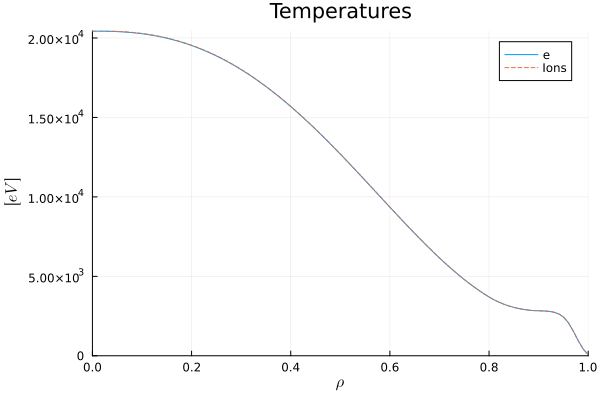

​


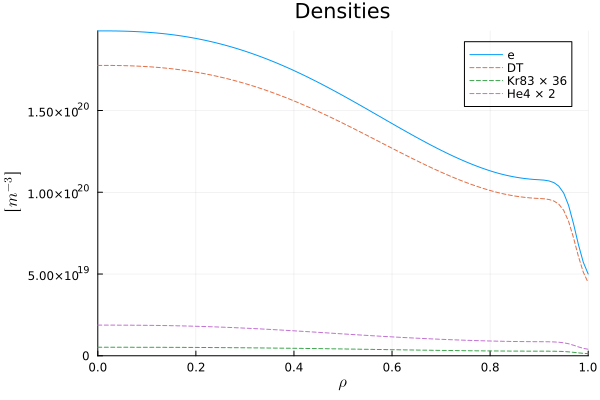

​


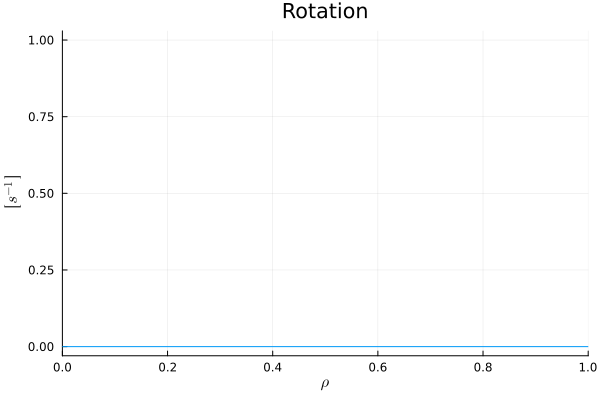

​


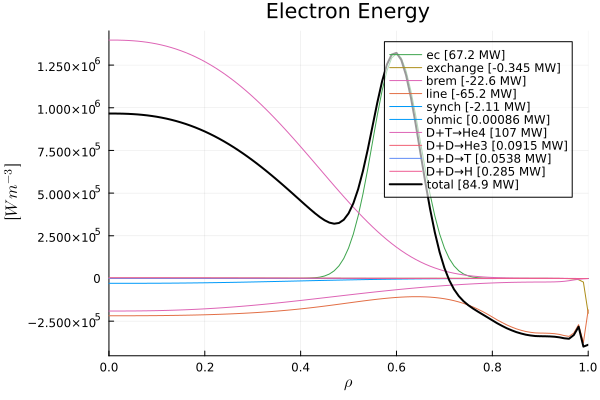

​


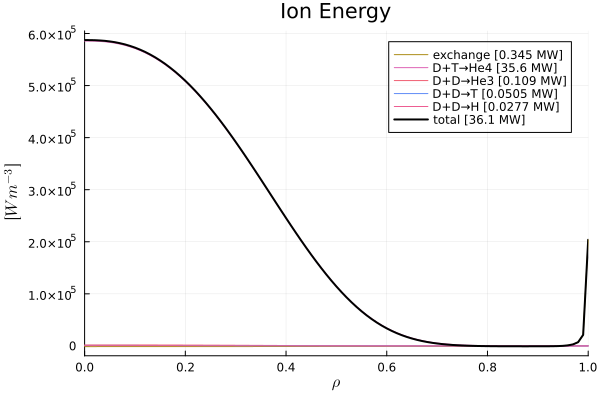

​


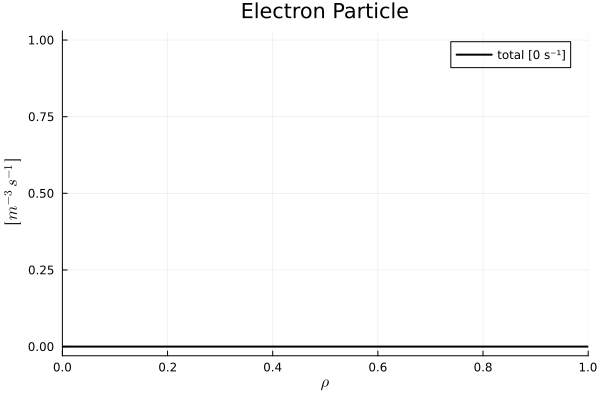

​


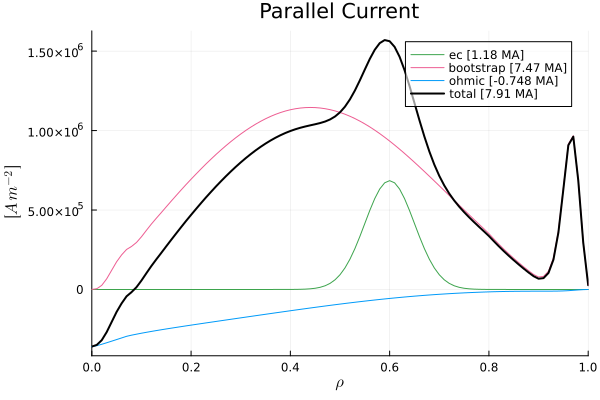

​


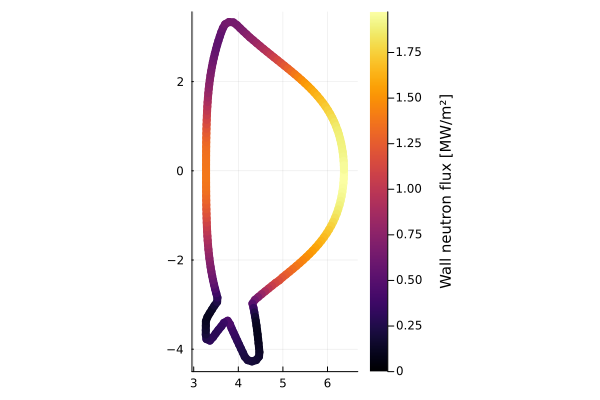

​


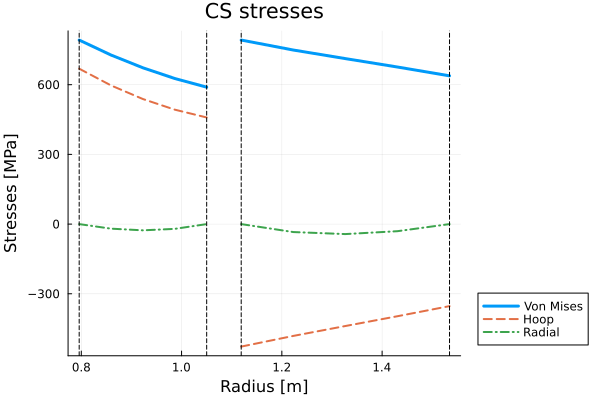

​


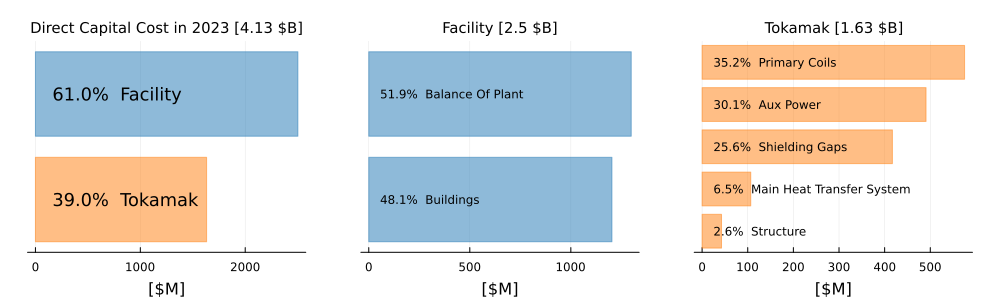

In [56]:
FUSE.digest(dd)

# Checks

## TF current density

In [57]:
using Printf

R0 = dd.equilibrium.vacuum_toroidal_field.r0
B0 = dd.equilibrium.vacuum_toroidal_field.b0[1]
Itf = 5*B0*R0
Rtf_start = dd.build.layer[4].start_radius
Rtf_end = dd.build.layer[4].end_radius
Atf = pi*(Rtf_end^2-Rtf_start^2)
Jtf = Itf/Atf
Btf = 0.2*Itf/(Rtf_end)

fHTSinTapeTF = 1/46.54
ratioSCtoCopperTF = 1.0
fractionCableTF = (1-dd.build.tf.technology.fraction_stainless-dd.build.tf.technology.fraction_void)
fractionTapeTF = fractionCableTF * ratioSCtoCopperTF/(1+ratioSCtoCopperTF)
fractionSCTF = fHTSinTapeTF * fractionTapeTF

Jsc = Jtf/fractionSCTF

Jcrit_sc = FUSE.YBCO_Jcrit(Btf,0.0,dd.build.tf.technology.temperature)[1]/1e6

Jcrit_tf = Jcrit_sc * fractionSCTF

@printf("R_0 = %.2f m\n",R0)
@printf("B_0 = %.2f T\n",B0)
@printf("I_TF = %.2f MA\n", Itf)
@printf("J_TF = %.2f MA/m^2\n", Jtf)
@printf("B_TF = %.2f T\n", Btf)
@printf("fractionCableTF = %.4f \n", fractionCableTF)
@printf("fractionTapeTF = %.4f \n", fractionTapeTF)
@printf("fractionSCTF = %.4f \n", fractionSCTF)

@printf("J_sc = %.2f MA/m^2\n", Jsc)

@printf("Jcrit_sc = %.2f MA/m^2\n", Jcrit_sc)
@printf("Jcrit_tf = %.2f MA/m^2\n", Jcrit_tf)
@printf("Jmargin_tf = %.2f \n", (Jcrit_tf-Jtf)/Jtf)
@printf("Jmargin_sc = %.2f \n", (Jcrit_sc-Jsc)/Jsc)



R_0 = 4.82 m
B_0 = 4.71 T
I_TF = 113.51 MA
J_TF = 32.77 MA/m^2
B_TF = 14.80 T
fractionCableTF = 0.0970 
fractionTapeTF = 0.0485 
fractionSCTF = 0.0010 
J_sc = 31452.66 MA/m^2
Jcrit_sc = 47179.61 MA/m^2
Jcrit_tf = 49.16 MA/m^2
Jmargin_tf = 0.50 
Jmargin_sc = 0.50 


## Power Balance

In [58]:
#display(dd.balance_of_plant)
#display(dd.blanket)

total_source = IMAS.total_sources(dd.core_sources,dd.core_profiles.profiles_1d[1])
radiation_losses = IMAS.radiation_losses(dd.core_sources)
display(total_source)

total_source_electrons = total_source.electrons.power_inside[end]
total_source_ions = total_source.total_ion_power_inside[end]
power_heat = total_source_electrons + total_source_ions - radiation_losses

powerAux = dd.ec_launchers.beam[1].power_launched.data[1]
powerAuxElectric = dd.balance_of_plant.power_electric_plant_operation.system[1].power[1]
powerBoP = dd.balance_of_plant.power_electric_plant_operation.system[2].power[1]

powerLine = dd.core_sources.source[8].profiles_1d[1].electrons.power_inside[end]
powerSync = dd.core_sources.source[4].profiles_1d[1].electrons.power_inside[end]
powerBrehm = dd.core_sources.source[3].profiles_1d[1].electrons.power_inside[end]
powerRad = powerLine + powerSync + powerBrehm

powerFusion = dd.summary.fusion.power.value[1]*5
powerNeutrons = powerFusion*0.8
powerAlphas = powerFusion*0.2
powerHeat = powerAlphas + powerAux
blanketMult = act.ActorBlanket.blanket_multiplier
powerRadFrac = powerRad/powerHeat

powerLFSBlanket = dd.blanket.module[1].time_slice[1].power_thermal_extracted
#powerHFSBlanket = dd.blanket.module[2].time_slice[1].power_thermal_extracted
powerBlanket = powerLFSBlanket #+ powerHFSBlanket
powerBoPBreeder = dd.balance_of_plant.heat_transfer.breeder.heat_load[1]
powerBoPWall = dd.balance_of_plant.heat_transfer.wall.heat_load[1]
powerBoPDivertors = dd.balance_of_plant.heat_transfer.divertor.heat_load[1]
powerDivertors = dd.divertors.divertor[1].power_thermal_extracted.data[1]
powerSOL = powerAlphas + powerAux + powerRad
fractionNeutronEnergyCaptured = powerBlanket / blanketMult / powerNeutrons

powerRunPlant = powerBoP + powerAuxElectric
powerThermalCycle = dd.balance_of_plant.thermal_cycle.total_useful_heat_power[1]
powerElectricGross = dd.balance_of_plant.thermal_cycle.power_electric_generated[1]
powerElectricNet = powerElectricGross - powerRunPlant

@printf("total_source_electrons = %.2f MW\n",total_source_electrons/1e6)
@printf("total_source_ions = %.2f MW\n",total_source_ions/1e6)
@printf("radiation_losses = %.2f MW\n",radiation_losses/1e6)
@printf("power_heat = %.2f MW\n",power_heat/1e6)
@printf("\n")
@printf("powerFusion = %.2f MW\n",powerFusion/1e6)
@printf("powerNeutrons = %.2f MW\n",powerNeutrons/1e6)
@printf("powerLFSBlanket = %.2f MW\n",powerLFSBlanket/1e6)
#@printf("powerHFSBlanket = %.2f MW\n",powerHFSBlanket/1e6)
@printf("powerBlanket = %.2f MW\n",powerBlanket/1e6)
@printf("powerBoPBreeder = %.2f MW\n",powerBoPBreeder/1e6)
@printf("fractionNeutronEnergyCaptured = %.3f \n",fractionNeutronEnergyCaptured)
@printf("\n")
@printf("powerLine = %.2f MW\n",powerLine/1e6)
@printf("powerSync = %.2f MW\n",powerSync/1e6)
@printf("powerBrehm = %.2f MW\n",powerBrehm/1e6)
@printf("powerRad = %.2f MW\n",powerRad/1e6)
@printf("powerBoPWall = %.2f MW\n",powerBoPWall/1e6)
@printf("\n")
@printf("powerAux = %.2f MW\n",powerAux/1e6)
@printf("powerAlphas = %.2f MW\n",powerAlphas/1e6)
@printf("powerHeat = %.2f MW\n",powerHeat/1e6)
@printf("RadFrac = %.3f\n",-1*powerRadFrac)
@printf("powerSOL = %.2f MW\n",powerSOL/1e6)
@printf("powerBoPDivertors = %.2f MW\n",powerBoPDivertors/1e6)
@printf("powerDivertors = %.2f MW\n",powerDivertors/1e6)
@printf("\n")
@printf("powerAuxElectric = %.2f MW\n",powerAuxElectric/1e6)
@printf("powerBoP = %.2f MW\n",powerBoP/1e6)
@printf("powerRunPlant = %.2f MW\n",powerRunPlant/1e6)
@printf("powerThermalCycle = %.2f MW\n",powerThermalCycle/1e6)
@printf("powerElectricGross = %.2f MW\n",powerElectricGross/1e6)
@printf("powerElectricNet = %.2f MW\n",powerElectricNet/1e6)



profiles_1d
├─ current_parallel_inside ➡ 101-element Vector{Float64} [A]
├─ electrons
│  ├─ energy ➡ 101-element Vector{Float64} [W.m^-3]
│  ├─ particles ➡ 101-element Vector{Float64} [m^-3.s^-1] (all 0.0)
│  ├─ particles_inside ➡ Function [s^-1]
│  └─ power_inside ➡ 101-element Vector{Float64} [W]
├─ grid
│  ├─ area ➡ 101-element Vector{Float64} [m^2]
│  ├─ psi ➡ Function [Wb]
│  ├─ psi_norm ➡ Function
│  ├─ rho_tor_norm ➡ 101-element Vector{Float64}
│  ├─ surface ➡ 101-element Vector{Float64} [m^2]
│  └─ volume ➡ 101-element Vector{Float64} [m^3]
├─ j_parallel ➡ 101-element Vector{Float64} [A.m^-2]
├─ momentum_tor ➡ 101-element Vector{Float64} [kg.m^-1.s^-2] (all 0.0)
├─ time ➡ 0 [s]
├─ torque_tor_inside ➡ Function [kg.m^2.s^-2]
├─ total_ion_energy ➡ 101-element Vector{Float64} [W.m^-3]
└─ total_ion_power_inside ➡ 101-element Vector{Float64} [W]


LoadError: Bad expression summary.fusion.power.value
MethodError: no method matching fusion_plasma_power(::IMASDD.core_profiles__profiles_1d{Float64})
Closest candidates are:
  fusion_plasma_power(!Matched::IMASDD.dd) at ~/.julia/dev/IMAS/src/physics/nuclear.jl:382
  fusion_plasma_power(!Matched::IMASDD.core_profiles) at ~/.julia/dev/IMAS/src/physics/nuclear.jl:391
Stacktrace:
  [1] (::IMAS.var"#859#861")(time::Vector{Float64}; dd::IMASDD.dd{Float64}, summary::IMASDD.summary{Float64}, #unused#::Base.Pairs{Symbol, IMASDD.IDS, Tuple{Symbol, Symbol}, NamedTuple{(:fusion, :power), Tuple{IMASDD.summary__fusion{Float64}, IMASDD.summary__fusion__power{Float64}}}})
    @ IMAS ~/.julia/dev/IMAS/src/expressions/dynamic.jl:574
  [2] exec_expression_with_ancestor_args(ids::IMASDD.IDS, field::Symbol, func::IMAS.var"#859#861")
    @ IMASDD ~/.julia/dev/IMASDD/src/data.jl:633
  [3] _getproperty(ids::IMASDD.IDS, field::Symbol)
    @ IMASDD ~/.julia/dev/IMASDD/src/data.jl:426
  [4] getproperty(ids::IMASDD.IDS, field::Symbol)
    @ IMASDD ~/.julia/dev/IMASDD/src/data.jl:334
  [5] top-level scope
    @ In[58]:21
  [6] eval
    @ ./boot.jl:368 [inlined]
  [7] include_string(mapexpr::typeof(REPL.softscope), mod::Module, code::String, filename::String)
    @ Base ./loading.jl:1428
  [8] softscope_include_string(m::Module, code::String, filename::String)
    @ SoftGlobalScope ~/.julia/packages/SoftGlobalScope/u4UzH/src/SoftGlobalScope.jl:65
  [9] execute_request(socket::ZMQ.Socket, msg::IJulia.Msg)
    @ IJulia ~/.julia/packages/IJulia/6TIq1/src/execute_request.jl:67
 [10] #invokelatest#2
    @ ./essentials.jl:729 [inlined]
 [11] invokelatest
    @ ./essentials.jl:726 [inlined]
 [12] eventloop(socket::ZMQ.Socket)
    @ IJulia ~/.julia/packages/IJulia/6TIq1/src/eventloop.jl:8
 [13] (::IJulia.var"#15#18")()
    @ IJulia ./task.jl:484

## Confinement scaling factor

In [59]:
import NumericalIntegration: integrate, cumul_integrate

#display(dd.equilibrium)
#display(dd.summary)

Ip = dd.equilibrium.time_slice[2].global_quantities.ip[1]/1e6
Bt = dd.equilibrium.vacuum_toroidal_field.b0[1]
R0 = dd.equilibrium.vacuum_toroidal_field.r0[1]
Ptransp = (powerHeat-powerBrehm)/1e6
ne = dd.summary.volume_average.n_e.value[1]/1e19
kappa = dd.equilibrium.time_slice[2].boundary.elongation[1]
a = dd.equilibrium.time_slice[2].boundary.minor_radius[1]
A = R0/a

betaN_eq = dd.equilibrium.time_slice[2].global_quantities.beta_normal[1]
betaT_eq = dd.equilibrium.time_slice[2].global_quantities.beta_tor[1]
betaP_eq = dd.equilibrium.time_slice[2].global_quantities.beta_pol[1]

betaN_mhd = dd.summary.global_quantities.beta_tor_norm_mhd.value[1]
betaN_th = dd.summary.global_quantities.beta_tor_thermal_norm.value[1]
betaN = dd.summary.global_quantities.beta_tor_norm.value[1]

betaP_mhd = dd.summary.global_quantities.beta_pol_mhd.value[1]
betaT_mhd = dd.summary.global_quantities.beta_tor_mhd.value[1]
betaT = dd.summary.global_quantities.beta_tor.value[1]

Pheat = powerHeat
Wplasma = dd.equilibrium.time_slice[2].global_quantities.energy_mhd[1]
cp1d = dd.core_profiles.profiles_1d[1]
Wthermal = 3/2*integrate(cp1d.grid.volume,cp1d.pressure_thermal)

#taue = Wplasma / Pheat
taue = Wthermal / Pheat

tau98 = 0.0562*(Ip)^(0.93)*Bt^(0.15)*Ptransp^(-0.69)*ne^(0.41)*2.5^(0.19)*R0^(1.97)*A^(-0.58)*kappa^(0.78)
H98 = taue / tau98

tau03 = 0.028*(Ip)^(0.83)*Bt^(0.07)*Ptransp^(-0.55)*ne^(0.49)*2.5^(0.14)*R0^(2.11)*A^(-0.3)*kappa^(0.75)
H03 = taue / tau03

@printf("Ip = %.2f MA\n",Ip)
@printf("Bt = %.2f T\n",Bt)
@printf("R0 = %.2f m\n",R0)
@printf("Ptransp = %.2f MW\n",Ptransp)
@printf("ne = %.2f e19 /m^3\n",ne)
@printf("kappa = %.2f \n",kappa)
@printf("A = %.2f\n",A)
@printf("\n")
@printf("Pheat = %.2f MW\n",Pheat/1e6)
@printf("Wplasma = %.2f MJ\n", Wplasma/1e6)
@printf("taue = %.3f s\n", taue)
@printf("tau98 = %.3f s\n", tau98)
@printf("H98 = %.3f\n", H98)
@printf("tau03 = %.3f s\n", tau03)
@printf("H03 = %.3f\n", H03)
@printf("\n")
@printf("betaN_tor_norm_mhd = %.3f\n",betaN_mhd)
@printf("betaN_tor_thermal_norm = %.3f\n",betaN_th)
@printf("betaN_tor_norm = %.3f\n",betaN)
@printf("betaN_eq = %.3f\n", betaN_eq)
@printf("betaT_eq = %.5f\n", betaT_eq)
@printf("betaP_eq = %.3f\n", betaP_eq)
@printf("betaT_mhd = %.5f\n", betaT_mhd)
@printf("betaP_mhd = %.3f\n", betaP_mhd)
@printf("betaT = %.5f\n", betaT)




LoadError: UndefVarError: powerHeat not defined

## Costing

In [60]:
display(dd.costing)

costing
├─ availability ➡ 0.8
├─ construction_start_year ➡ 2023 [year]
├─ cost_decommissioning
│  └─ cost ➡ Function [$M]
├─ cost_direct_capital
│  ├─ cost ➡ Function [$M]
│  └─ system
│     ├─ 1
│     │  ├─ cost ➡ Function [$M]
│     │  ├─ name ➡ "facility"
│     │  └─ subsystem
│     │     ├─ 1
│     │     │  ├─ cost ➡ 1298.88 [$M]
│     │     │  └─ name ➡ "balance of plant"
│     │     └─ 2
│     │        ├─ cost ➡ 1203.45 [$M]
│     │        └─ name ➡ "buildings"
│     └─ 2
│        ├─ cost ➡ Function [$M]
│        ├─ name ➡ "tokamak"
│        └─ subsystem
│           ├─ 1
│           │  ├─ cost ➡ 575.125 [$M]
│           │  └─ name ➡ "primary coils"
│           ├─ 2
│           │  ├─ cost ➡ 490.699 [$M]
│           │  └─ name ➡ "aux power"
│           ├─ 3
│           │  ├─ cost ➡ 416.992 [$M]
│           │  └─ name ➡ "shielding gaps"
│           ├─ 4
│           │  ├─ cost ➡ 106.598 [$M]
│           │  └─ name ➡ "main heat transfer system"
│           └─ 5
│              ├─ cost 

In [61]:
#display(dd.build.tf)

primary_coils_hfs = IMAS.get_build(dd.build, type = IMAS._tf_, fs = IMAS._hfs_)
display(primary_coils_hfs)

volumeTF = dd.build.layer[4].volume
stainlessFractionTF = dd.build.tf.technology.fraction_stainless
voidFractionTF = dd.build.tf.technology.fraction_void
ratioTF = dd.build.tf.technology.ratio_SC_to_copper
volumeSteelTF = volumeTF * stainlessFractionTF
volumeCopperTF = volumeTF*(1-stainlessFractionTF-voidFractionTF)*1/(1+ratioTF)
volumeSCTF = volumeTF*(1-stainlessFractionTF-voidFractionTF)*ratioTF/(1+ratioTF)

volumeOH = dd.build.layer[2].volume
stainlessFractionOH = dd.build.oh.technology.fraction_stainless
voidFractionOH = dd.build.oh.technology.fraction_void
ratioOH = dd.build.oh.technology.ratio_SC_to_copper
volumeSteelOH = volumeOH * stainlessFractionOH
volumeCopperOH = volumeOH*(1-stainlessFractionOH-voidFractionOH)*1/(1+ratioOH)
volumeSCOH = volumeOH*(1-stainlessFractionOH-voidFractionOH)*ratioOH/(1+ratioOH)

production_increase = dd.costing.future.learning.hts.production_increase
learning_rate = dd.costing.future.learning.hts.learning_rate
hts_discount_factor = production_increase^(log(learning_rate) / log(2))

costSteelTF = volumeSteelTF * 0.36
costCopperTF = volumeCopperTF * 0.5
costSCTF = volumeSCTF * (87.5/2) * hts_discount_factor

costSteelOH = volumeSteelOH * 0.36
costCopperOH = volumeCopperOH * 0.5
costSCOH = volumeSCOH * (87.5/2) * hts_discount_factor

costTF = 1.5*(costSteelTF+costCopperTF+costSCTF)
costTFtoday = costTF * 300/240
costPrimaryCoils = dd.costing.cost_direct_capital.system[2].subsystem[2].cost 

@printf("volumeTF = %.2f m^3\n", volumeTF)
@printf("volumeSCTF = %.2f m^3\n", volumeSCTF)
@printf("stainlessFractionTF = %.3f\n", stainlessFractionTF)
@printf("volumeOH = %.2f m^3\n", volumeOH)
@printf("volumeSCOH = %.2f m^3\n", volumeSCOH)
@printf("stainlessFractionOH = %.3f\n", stainlessFractionOH)
@printf("\n")
@printf("prodution_increase = %.2f\n",production_increase)
@printf("learning_rate = %.2f\n", learning_rate)
@printf("hts_discount_factor = %.2f\n", hts_discount_factor)
@printf("\n")
@printf("costSteelTF = %.2f \$M\n",costSteelTF)
@printf("costCopperTF = %.2f \$M\n",costCopperTF)
@printf("costSCTF = %.2f \$M\n",costSCTF)
@printf("costSteelOH = %.2f \$M\n",costSteelOH)
@printf("costCopperOH = %.2f \$M\n",costCopperOH)
@printf("costSCOH = %.2f \$M\n",costSCOH)
@printf("costTF = %.2f \$M\n", costTF)
@printf("costTFtoday = %.2f \$M\n", costTFtoday)
@printf("costPrimaryCoils = %.2f \$M\n", costPrimaryCoils)

LoadError: `IMAS.get_build()` is obsolete. Use `get_build_layer()` and `get_build_index()` or `get_build_layers()` and `get_build_indexes()` instead

## Particle populations

In [62]:
display(dd.core_profiles.profiles_1d[1])
p0_tot = dd.core_profiles.profiles_1d[1].pressure[1]

nα0_fast = dd.core_profiles.profiles_1d[1].ion[3].density_fast[1]
nα0_th = dd.core_profiles.profiles_1d[1].ion[3].density_thermal[1]
ne0_th = dd.core_profiles.profiles_1d[1].electrons.density_thermal[1]
nDT0 = dd.core_profiles.profiles_1d[1].ion[1].density_thermal[1]
nKr0 = dd.core_profiles.profiles_1d[1].ion[2].density_thermal[1]

fα0 = (nα0_fast+nα0_th)/ne0_th
#fα0 = (nα0_th)/ne0_th
#fα0 = nα0_fast / (nα0_fast+nα0_th)

pα0_fast_perp = dd.core_profiles.profiles_1d[1].ion[3].pressure_fast_perpendicular[1]
pα0_fast_par = dd.core_profiles.profiles_1d[1].ion[3].pressure_fast_parallel[1]
pα0_th = dd.core_profiles.profiles_1d[1].ion[3].pressure_thermal[1]

pe0_fast_perp = dd.core_profiles.profiles_1d[1].electrons.pressure_fast_perpendicular[1]
pe0_fast_par = dd.core_profiles.profiles_1d[1].electrons.pressure_fast_parallel[1]
pe0_th = dd.core_profiles.profiles_1d[1].electrons.pressure_thermal[1]

pDT0_fast_perp = dd.core_profiles.profiles_1d[1].ion[1].pressure_fast_perpendicular[1]
pDT0_fast_par = dd.core_profiles.profiles_1d[1].ion[1].pressure_fast_parallel[1]
pDT0_th = dd.core_profiles.profiles_1d[1].ion[1].pressure_thermal[1]

@printf("nDT0 = %.2f 1e20/m^3\n", nDT0/1e20)
@printf("nKr0 = %.2f 1e18/m^3\n", nKr0/1e18)
@printf("fDT0 = %.4f\n", nDT0/ne0_th)
@printf("fKr0 = %.6f\n", nKr0/ne0_th)
@printf("\n")
@printf("p0_total = %.2f kPa\n",p0_tot/1e3)
@printf("\n")
@printf("pe0_fast_perp = %.2f kPa\n",pe0_fast_perp/1e3)
@printf("pe0_fast_par = %.2f kPa\n",pe0_fast_par/1e3)
@printf("pe0_thermal = %.2f kPa\n",pe0_th/1e3)
@printf("\n")
@printf("pDT0_fast_perp = %.2f kPa\n",pDT0_fast_perp/1e3)
@printf("pDT0_fast_par = %.2f kPa\n",pDT0_fast_par/1e3)
@printf("pDT0_thermal = %.2f kPa\n",pDT0_th/1e3)
@printf("\n")
@printf("pα0_fast_perp = %.2f kPa\n",pα0_fast_perp/1e3)
@printf("pα0_fast_par = %.2f kPa\n",pα0_fast_par/1e3)
@printf("pα0_thermal = %.2f kPa\n",pα0_th/1e3)
@printf("\n")
@printf("nα0_fast = %.4f 1e20/m^3\n",nα0_fast/1e20)
@printf("nα0_thermal = %.4f 1e20/m^3\n",nα0_th/1e20)
@printf("fα0 = %.4f\n", fα0)

1
├─ conductivity_parallel ➡ Function [ohm^-1.m^-1]
├─ electrons
│  ├─ density ➡ Function [m^-3]
│  ├─ density_fast ➡ Function [m^-3]
│  ├─ density_thermal ➡ 101-element Vector{Float64} [m^-3]
│  ├─ pressure ➡ Function [Pa]
│  ├─ pressure_fast_parallel ➡ Function [Pa]
│  ├─ pressure_fast_perpendicular ➡ Function [Pa]
│  ├─ pressure_thermal ➡ Function [Pa]
│  └─ temperature ➡ 101-element Vector{Float64} [eV]
├─ grid
│  ├─ area ➡ 101-element Vector{Float64} [m^2]
│  ├─ psi ➡ 101-element Vector{Float64} [Wb]
│  ├─ psi_norm ➡ 101-element Vector{Float64}
│  ├─ rho_tor_norm ➡ 101-element Vector{Float64}
│  ├─ surface ➡ 101-element Vector{Float64} [m^2]
│  └─ volume ➡ 101-element Vector{Float64} [m^3]
├─ ion
│  ├─ 1
│  │  ├─ density ➡ Function [m^-3]
│  │  ├─ density_fast ➡ 101-element Vector{Float64} [m^-3]
│  │  ├─ density_thermal ➡ 101-element Vector{Float64} [m^-3]
│  │  ├─ element
│  │  │  └─ 1
│  │  │     ├─ a ➡ 2.515 [Atomic Mass Unit]
│  │  │     └─ z_n ➡ 1 [Elementary Charge Unit]
│ 

nDT0 = 1.78 1e20/m^3
nKr0 = 0.15 1e18/m^3
fDT0 = 0.8937
fKr0 = 0.000730

p0_total = 1661.47 kPa

pe0_fast_perp = 0.00 kPa
pe0_fast_par = 0.00 kPa
pe0_thermal = 650.32 kPa

pDT0_fast_perp = 0.05 kPa
pDT0_fast_par = 0.05 kPa
pDT0_thermal = 746.59 kPa

pα0_fast_perp = 76.79 kPa
pα0_fast_par = 76.79 kPa
pα0_thermal = 33.42 kPa

nα0_fast = 0.0143 1e20/m^3
nα0_thermal = 0.0795 1e20/m^3
fα0 = 0.0472


## Equilibrium

In [63]:
display(dd.equilibrium)

q0 = dd.equilibrium.time_slice[2].global_quantities.q_axis

equilibrium
├─ time ➡ [-Inf,0] [s]
├─ time_slice
│  ├─ 1
│  │  ├─ boundary
│  │  │  ├─ elongation ➡ Function
│  │  │  ├─ elongation_lower ➡ Function
│  │  │  ├─ elongation_upper ➡ Function
│  │  │  ├─ geometric_axis
│  │  │  │  ├─ r ➡ Function [m]
│  │  │  │  └─ z ➡ Function [m]
│  │  │  ├─ minor_radius ➡ Function [m]
│  │  │  ├─ squareness ➡ Function
│  │  │  ├─ squareness_lower_inner ➡ Function
│  │  │  ├─ squareness_lower_outer ➡ Function
│  │  │  ├─ squareness_upper_inner ➡ Function
│  │  │  ├─ squareness_upper_outer ➡ Function
│  │  │  ├─ triangularity ➡ Function
│  │  │  ├─ triangularity_lower ➡ Function
│  │  │  └─ triangularity_upper ➡ Function
│  │  ├─ global_quantities
│  │  │  ├─ energy_mhd ➡ Function [J]
│  │  │  ├─ magnetic_axis
│  │  │  │  ├─ b_field_tor ➡ Function [T]
│  │  │  │  ├─ r ➡ Function [m]
│  │  │  │  └─ z ➡ Function [m]
│  │  │  ├─ psi_axis ➡ Function [Wb]
│  │  │  ├─ psi_boundary ➡ 0.1 [Wb]
│  │  │  ├─ q_95 ➡ Function
│  │  │  └─ q_axis ➡ Function
│  │  ├─ pr

1.8386806271714196